In [41]:
import pandas as pd
import numpy as np

In [6]:
lung1 = pd.read_csv('../../rmbatch_dge/Lung1_rm.batch_dge.txt', header=0, sep=' ', quotechar='"')
lung2 = pd.read_csv('../../rmbatch_dge/Lung2_rm.batch_dge.txt', header=0, sep=' ', quotechar='"')
lung3 = pd.read_csv('../../rmbatch_dge/Lung3_rm.batch_dge.txt', header=0, sep=' ', quotechar='"')

In [9]:
cell_types = pd.read_csv('../../MCA_assign.csv', index_col=0)

In [10]:
cell_types = cell_types[cell_types.Tissue == 'Lung']
cell_types = cell_types.set_index('Cell.name')
cell_types = cell_types[['ClusterID', 'Batch']]

In [25]:
cell_types.loc[cell_types.index[:5], 'Cell.name']

106053    Lung_1.AAAACGAGATGGAGGACT
106054    Lung_1.AAAACGAGTTTACGTGGC
106055    Lung_1.AAAACGATACAGTCACTT
106056    Lung_1.AAAACGATACAGTTTAGG
106057    Lung_1.AAAACGATCTCTCATCCC
Name: Cell.name, dtype: object

In [27]:
lung1 = lung1.transpose()

In [35]:
lung2 = lung2.transpose()
lung3 = lung3.transpose()

In [38]:
lung = pd.concat([lung1, lung2, lung3])

In [39]:
lung = lung.join(cell_types)

In [48]:
lung = lung[~lung.Batch.isna()]

In [49]:
lung.fillna(0, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [55]:
X = lung[lung.columns[lung.columns != 'ClusterID']]

In [57]:
y = lung.ClusterID

In [60]:
from sklearn.model_selection import train_test_split

In [75]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [61]:
from catboost import CatBoostClassifier, Pool, cv

In [83]:
model = CatBoostClassifier(
    iterations=200,
    random_seed=42,
    logging_level='Silent',
    loss_function='MultiClass'
)

In [74]:
y = y.str.replace('Lung_', '')

In [84]:
model.fit(
    X_train, y_train, [X.shape[1] - 1], eval_set=(X_validation, y_validation), plot=True
)

MetricVisualizer(data={'catboost_info': {'path': 'catboost_info', 'name': 'catboost_info', 'content': {'passed…

In [414]:
model2 = CatBoostClassifier(
    iterations=200,
    random_seed=42,
    logging_level='Silent',
    loss_function='MultiClass',
    l2_leaf_reg=7.0,
    learning_rate=0.325,
)

In [416]:
model2.fit(
    X_train, y_train, [X.shape[1] - 1], eval_set=(X_validation, y_validation), plot=True
)

MetricVisualizer(data={'catboost_info': {'path': 'catboost_info', 'name': 'catboost_info', 'content': {'passed…

In [199]:
def load_10x(path, batch_label):
    mtx = pd.read_csv('{}/matrix.mtx'.format(path), skiprows=3, sep=' ', header=None)
    genes = pd.read_table('{}/genes.tsv'.format(path), header=None, index_col=1)
    cells = pd.read_table('{}/barcodes.tsv'.format(path), header=None, index_col=0)
    exp = scipy.sparse.csc_matrix((mtx[2], (mtx[0] - 1, mtx[1] - 1)), shape=(len(genes), len(cells)))
    exp = pd.SparseDataFrame(exp)
    exp.columns = cells.index
    exp = exp.transpose()
    exp.column = genes.index
    exp = exp.to_dense()
    exp['Batch'] = batch_label
    return exp

In [85]:
import scipy.sparse

In [86]:
sc1mtx = pd.read_csv('../../SC01/matrix.mtx', skiprows=3, sep=' ', header=None)

In [88]:
sc1genes = pd.read_table('../../SC01/genes.tsv', header=None, index_col=1)

In [90]:
sc1cells = pd.read_table('../../SC01/barcodes.tsv', header=None, index_col=0)

In [95]:
sc1 = scipy.sparse.csc_matrix((sc1mtx[2], (sc1mtx[0] - 1, sc1mtx[1] - 1)), shape=(len(sc1genes), len(sc1cells)))

In [96]:
sc1

<27998x6767 sparse matrix of type '<class 'numpy.int64'>'
	with 8034577 stored elements in Compressed Sparse Column format>

In [97]:
sc1 = pd.SparseDataFrame(sc1)

In [101]:
sc1.columns = sc1cells.index

In [103]:
sc1 = sc1.transpose()

In [105]:
sc1.columns = sc1genes.index

In [113]:
sc1input = sc1.loc[:,sc1.columns.isin(X_train.columns)]

In [119]:
sc1input['Batch'] = ['SC01'] * len(sc1input.index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [123]:
sc1input = sc1input.to_dense()

In [126]:
sc1input.fillna(0, inplace=True)

In [154]:
missing_cols = X_train.columns[~X_train.columns.isin(sc1input.columns)]

In [158]:
sc1input[list(missing_cols)] = pd.DataFrame([[0] * len(missing_cols)], index=sc1input.index)

In [169]:
sc1input = sc1input.groupby(level=0, axis=1).sum()

In [171]:
predictions = model.predict_proba(sc1input[X_train.columns])

In [179]:
preds = model.predict(sc1input[X_train.columns])

(array([  6.,   5.,  10.,   7.,  13.,  14.,  19.,  14.,  16.,  18.,  19.,
         21.,  20.,  21.,  22.,  30.,  34.,  34.,  31.,  42.,  41.,  33.,
         35.,  51.,  46.,  53.,  51.,  52.,  42.,  63.,  66.,  69.,  58.,
         57.,  56.,  60.,  63.,  61.,  64.,  42.,  58.,  55.,  56.,  67.,
         71.,  64.,  71.,  71.,  99.,  80.,  86.,  76.,  55.,  77.,  92.,
        101.,  92.,  77.,  87.,  78.,  55.,  72.,  78.,  85.,  72.,  78.,
         90.,  77.,  64.,  64.,  52.,  53.,  48.,  72.,  58.,  43.,  72.,
         58.,  68.,  71.,  84.,  90.,  87.,  83.,  88.,  75., 111., 121.,
        127., 136., 131., 150., 139.,  75.,  62.,  59., 103., 203., 453.,
         88.]),
 array([0.11341044, 0.12168059, 0.12995074, 0.13822089, 0.14649104,
        0.1547612 , 0.16303135, 0.1713015 , 0.17957165, 0.1878418 ,
        0.19611196, 0.20438211, 0.21265226, 0.22092241, 0.22919257,
        0.23746272, 0.24573287, 0.25400302, 0.26227317, 0.27054333,
        0.27881348, 0.28708363, 0.29535378, 0.

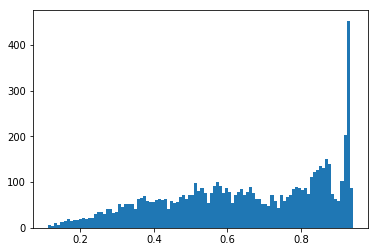

In [187]:
plt.hist(np.max(predictions, axis=1), bins=100)

In [186]:
import matplotlib.pyplot as plt

In [185]:
%matplotlib inline

In [188]:
scipy.stats.describe(np.max(predictions, axis=1))

DescribeResult(nobs=6767, minmax=(0.11341043525879073, 0.9404256509013502), mean=0.6421022268000315, variance=0.04678091256143142, skewness=-0.3521421120833823, kurtosis=-0.9909826105164821)

In [195]:
preds = pd.DataFrame(preds)

In [209]:
preds.to_csv('./sc01-preds.csv')

In [198]:
model.save_model('./mca-lung-1.cbm')

In [200]:
preds['prob'] = np.max(predictions, axis=1)

In [203]:
preds = preds.rename({'0': 'cluster'})

In [205]:
preds.index = sc1input.index

In [207]:
preds.iloc[:5,]

,0,prob
0,,
AAACCTGAGACTAAGT-1,5.0,0.221829
AAACCTGAGGCCCTCA-1,2.0,0.592763
AAACCTGAGGTGACCA-1,5.0,0.722059
AAACCTGAGTACGACG-1,1.0,0.931378
AAACCTGCAACGATGG-1,4.0,0.207075


In [208]:
sc1input.iloc[:5,:5]

1,00R_AC107638.2,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik
0,,,,,
AAACCTGAGACTAAGT-1,0,0,0.0,0.0,0
AAACCTGAGGCCCTCA-1,0,0,0.0,0.0,0
AAACCTGAGGTGACCA-1,0,0,0.0,0.0,0
AAACCTGAGTACGACG-1,0,0,0.0,0.0,0
AAACCTGCAACGATGG-1,0,0,0.0,0.0,0


In [417]:
import sklearn

In [423]:
model = model.load_model('./mca-lung-1.cbm')

In [441]:
y1 = model2.predict(X_validation)

In [442]:
sklearn.metrics.accuracy_score(y1, y_validation.astype(int))

0.9198847262247839

In [210]:
ct = pd.read_csv('../../MCA_assign.csv', index_col=0)

In [250]:
ids = list(range(1, 45))

In [251]:
ids = list(map(lambda x: 'Lung_' + str(x), ids))

In [252]:
lung_ids = ct[ct.ClusterID.isin(ids)]

In [253]:
lung_ids = lung_ids[['ClusterID', 'Annotation']].drop_duplicates()

In [351]:
lung_ids.sort_values(by='ClusterID').to_csv('./MCA_clusters.csv')

In [342]:
lung_ids.ClusterID = lung_ids.ClusterID.str.replace('Lung_', '').astype(int)

In [349]:
lung_ids.Annotation = lung_ids.Annotation.str.replace('\(\)', '')

In [266]:
predictions = pd.DataFrame(predictions)

In [268]:
predictions['MAX'] = predictions.max(axis=1)

In [273]:
predictions['SECOND_MAX'] = predictions[predictions < predictions.MAX].max(axis=1)

In [284]:
predictions < predictions.MAX

,0,1,2,3,4,5,6,7,8,9,...,6757,6758,6759,6760,6761,6762,6763,6764,6765,6766
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,True,True,True,True,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,True,False,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,True,True,True,True,False,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
5,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
6,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
7,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
8,True,False,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
9,True,False,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


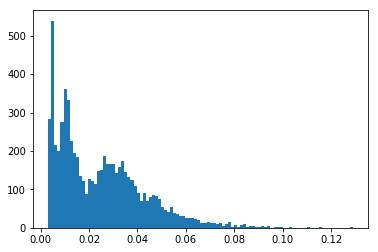

In [312]:
plt.hist(np.percentile(predictions, 90, axis=1), bins=100); None

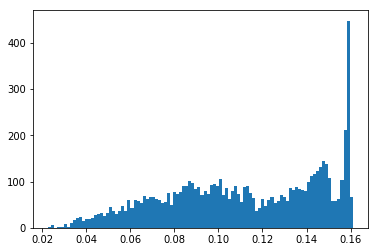

In [313]:
plt.hist(np.std(predictions, axis=1), bins=100); None

In [305]:
max2 = np.partition(predictions, predictions.shape[1] - 2)[:,-2:]

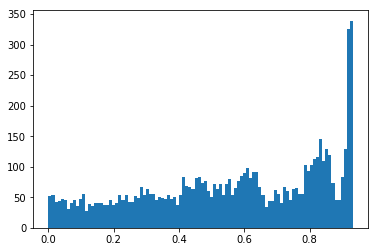

In [314]:
plt.hist(max2[:,-1] - max2[:,-2], bins=100); None

In [384]:
mca_clusters = pd.read_csv('./MCA_clusters.csv')

In [321]:
importances = pd.DataFrame(model._feature_importance, X_train.columns)

In [335]:
importances[importances[0] > 0].to_csv('./catboost_features.csv')

In [337]:
predictions.to_csv('./sc01-preds-full.csv')

In [338]:
import seaborn

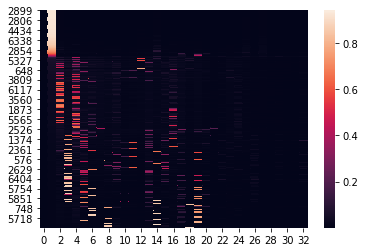

In [352]:
seaborn.heatmap(predictions.sort_values(list(predictions.columns[1:]), ascending=False))

In [354]:
predictions = predictions.iloc[:,1:]

In [357]:
predictions['cell_type'] = predictions.idxmax(axis=1)

In [377]:
predictions.sort_values(['cell_type', 'max_score'], ascending=[True, False], inplace=True)

In [364]:
for i in predictions.cell_type.unique():
    predictions[predictions.cell_type == i].sort_values(i, ascending=False, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


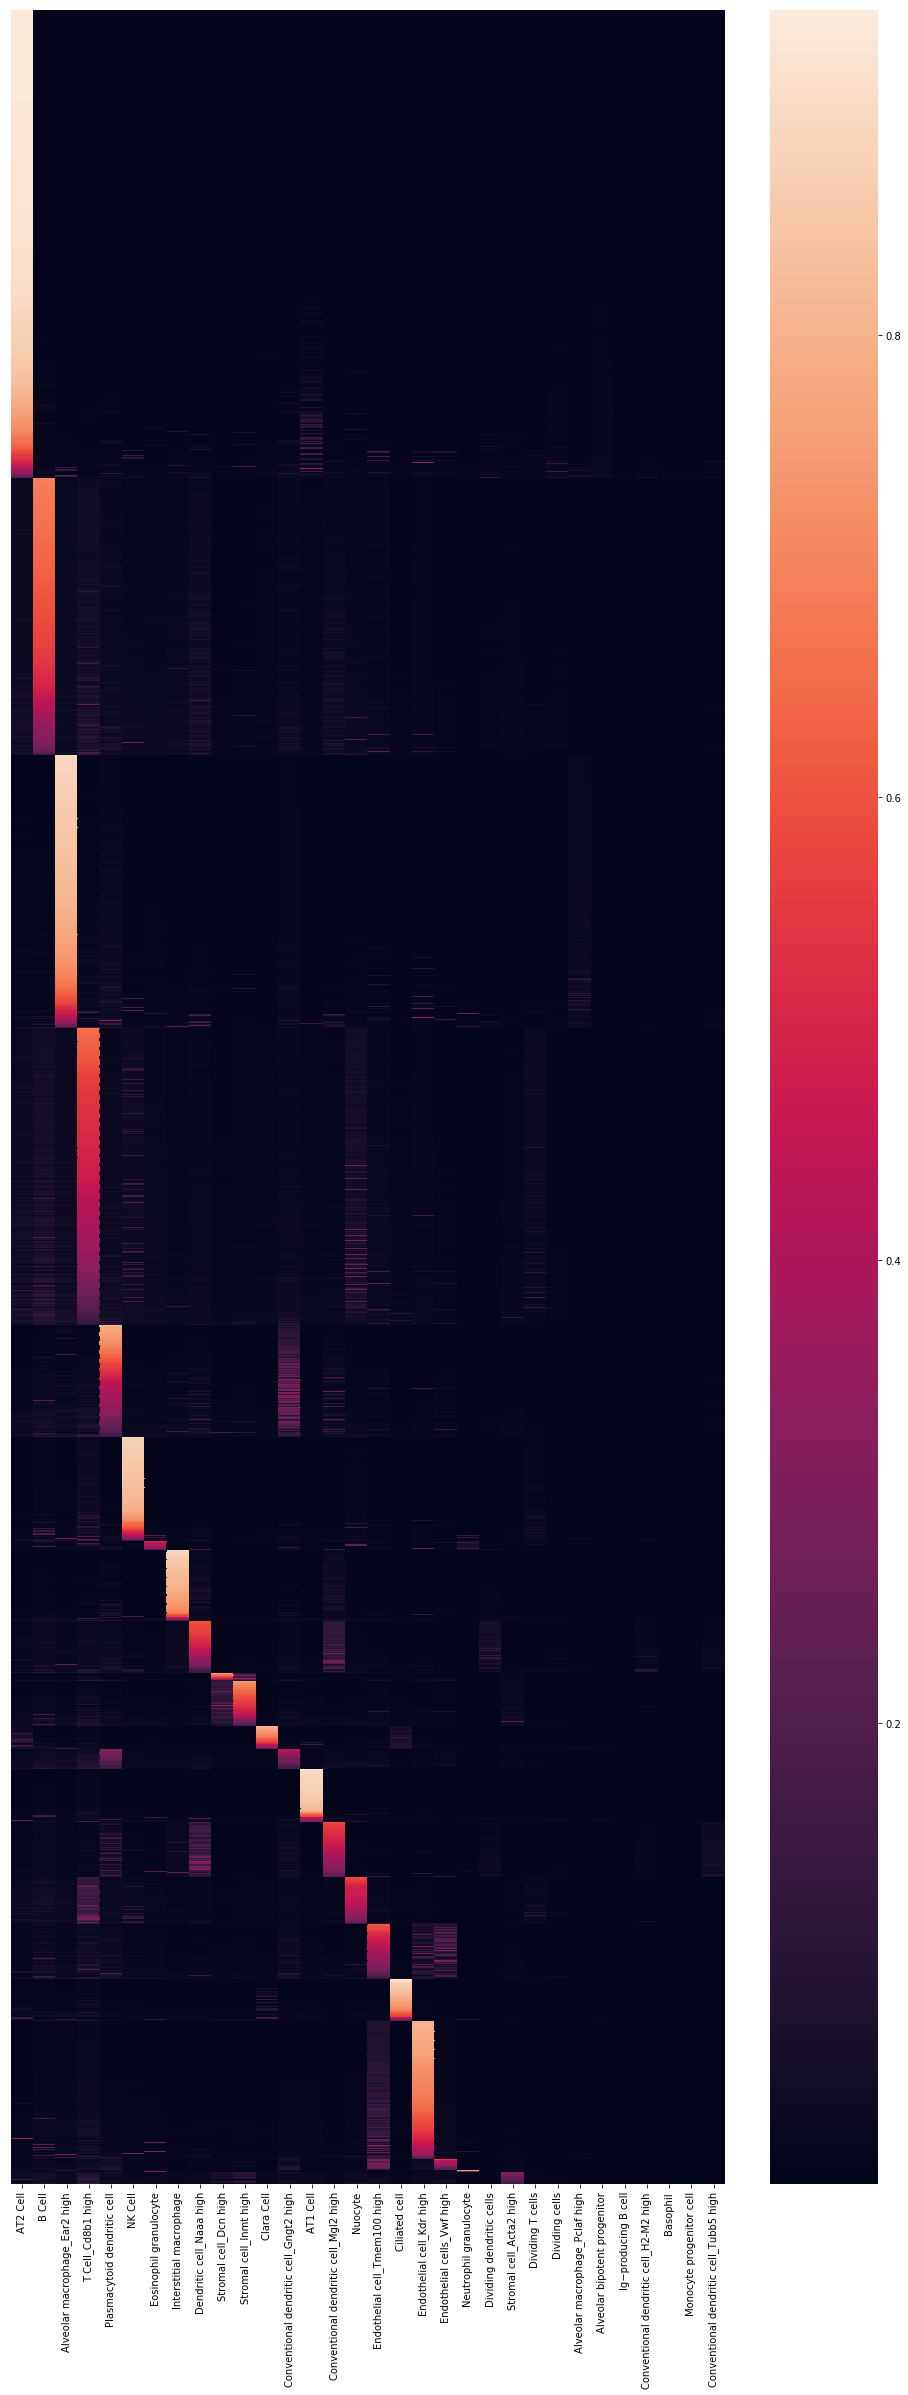

In [411]:
plt.figure(figsize = (16,40))
seaborn.heatmap(predictions[predictions.columns[:-2]], yticklabels=[])

In [375]:
predictions['max_score'] = predictions[predictions.columns[:-2]].max(axis=1)

In [394]:
predictions.columns = list(mca_clusters.Annotation) + list(predictions.columns[-2:])

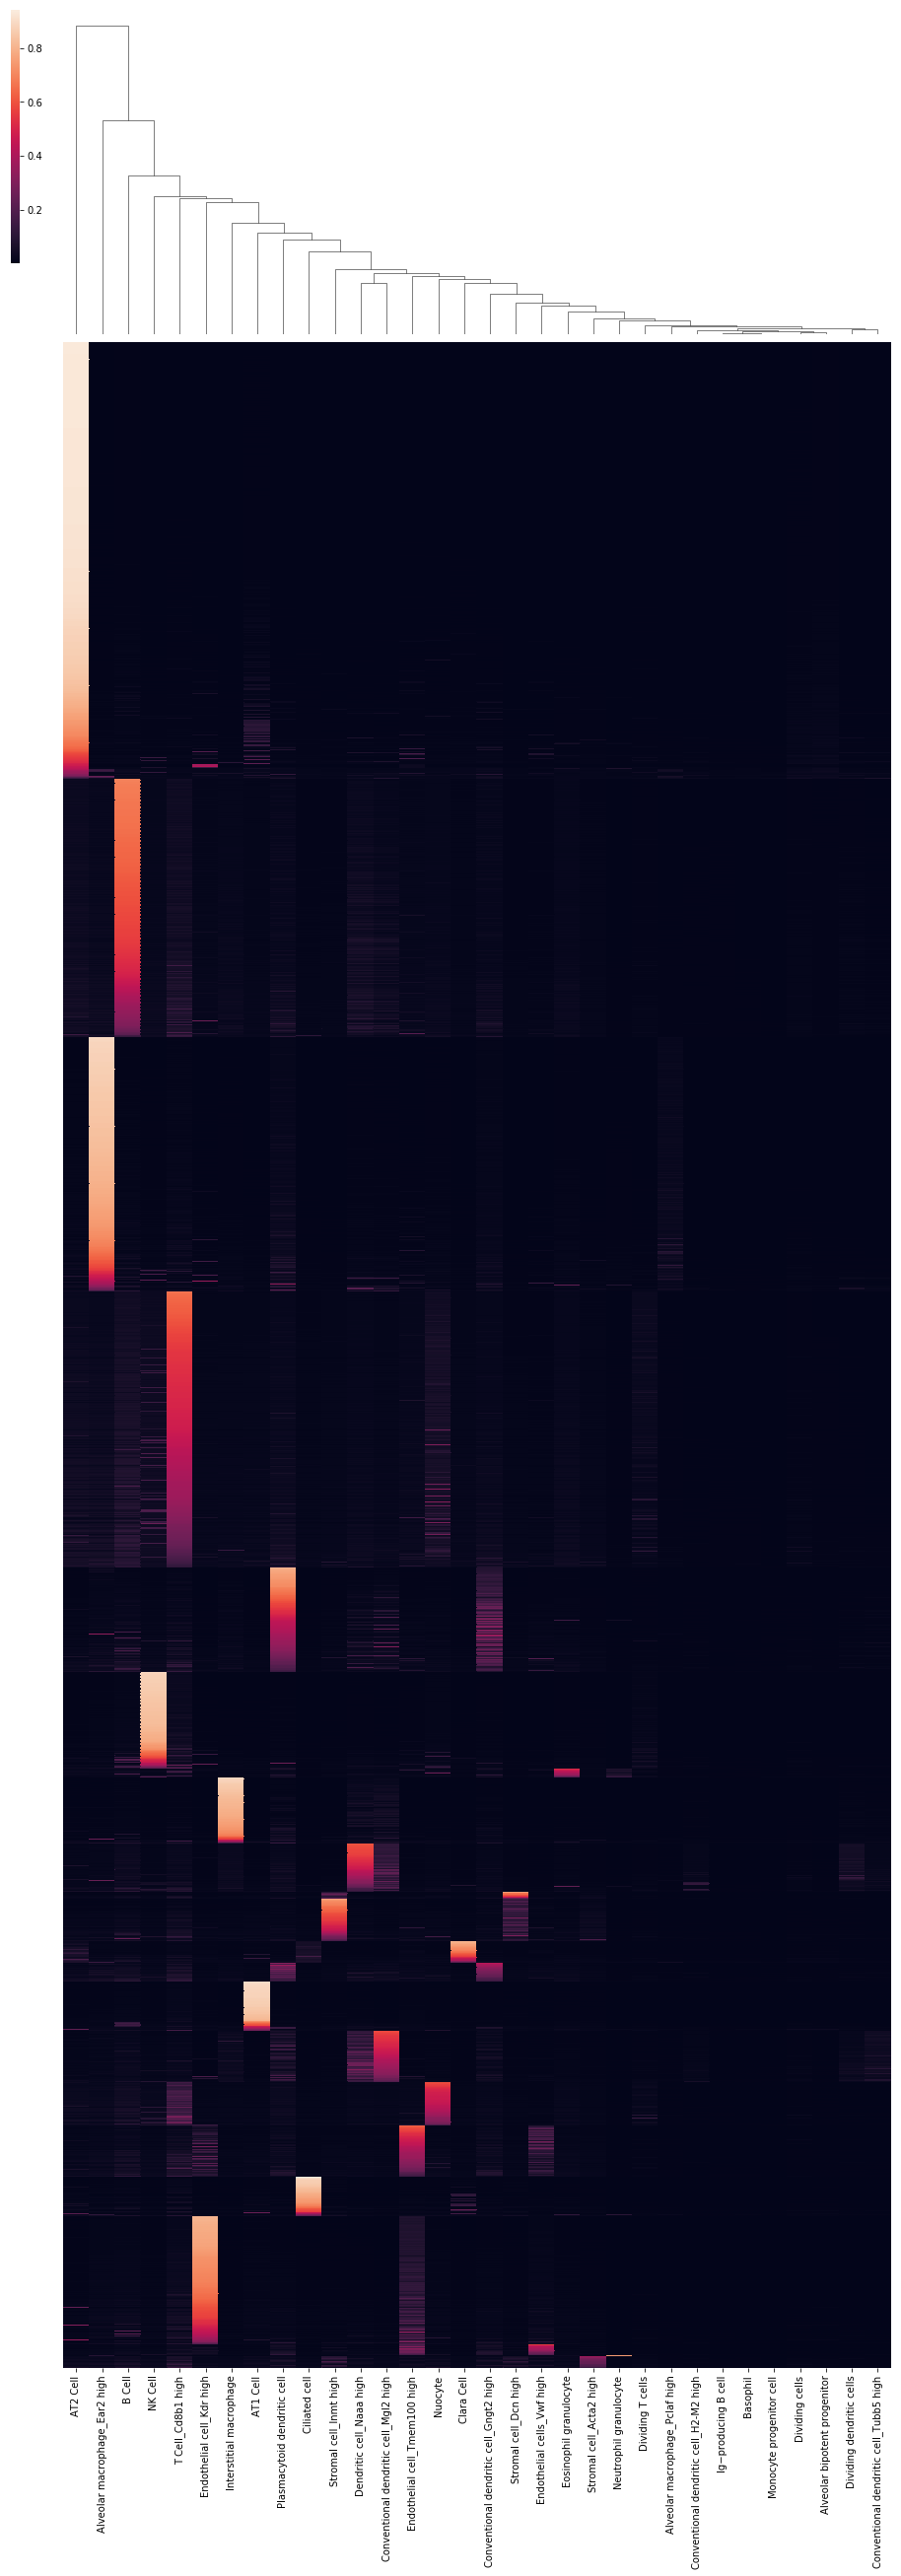

In [413]:
seaborn.clustermap(predictions[predictions.columns[:-2]], row_cluster=False, figsize=(16,44), yticklabels=[])